In [1]:
import os.path
import glob
from pathlib import Path

import numpy as np
import pandas as pd

from astropy.io import fits

import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

from photutils.aperture import EllipticalAnnulus, EllipticalAperture
from photutils.aperture import aperture_photometry, ApertureStats


In [2]:
obj = 'NGC5949'

In [3]:
paramFile = os.path.join('processingParams',obj+'.csv')
params = pd.read_csv(paramFile)

In [4]:
hfile = os.path.join('processed',obj,'H','combined','combined.fits')
rfile = os.path.join('processed',obj,'R','combined','combined.fits')

hhdu = fits.open(hfile)
rhdu = fits.open(rfile)

hheader = hhdu[0].header
rheader = rhdu[0].header

hsci = hhdu[0].data
rsci = rhdu[0].data

hvar = hhdu[1].data
rvar = rhdu[1].data

#Shift the r-band image:
rsci_shift = np.roll(rsci,
                    int(params.value[params.param == 'xshift'].values[0]),
                     axis=1)
rsci_shift = np.roll(rsci_shift,
                     int(params.value[params.param == 'yshift'].values[0]),
                     axis=0)
rvar_shift = np.roll(rvar,
                    int(params.value[params.param == 'xshift'].values[0]),
                     axis=1)
rvar_shift = np.roll(rvar_shift,
                     int(params.value[params.param == 'yshift'].values[0]),
                     axis=0)

hdu_sci = fits.PrimaryHDU(rsci_shift, header=rheader)
hdu_var = fits.ImageHDU(rvar_shift, header=rheader)
hdul = fits.HDUList([hdu_sci, hdu_var])
newfile = os.path.join('processed',obj,'R','combined','shifted.fits')
hdul.writeto(newfile, overwrite=True)

rsci_scaled = rsci_shift / params.value[params.param == 'scale'].values[0]
rvar_scaled = rvar_shift / params.value[params.param == 'scale'].values[0]

hdu_sci = fits.PrimaryHDU(rsci_scaled, header=rheader)
hdu_var = fits.ImageHDU(rvar_scaled, header=rheader)
hdul = fits.HDUList([hdu_sci, hdu_var])
newfile = os.path.join('processed',obj,'R','combined','scaled.fits')
hdul.writeto(newfile, overwrite=True)

sub_sci = hsci - rsci_scaled
sub_var = hvar

hdu_sci = fits.PrimaryHDU(sub_sci, header=hheader)
hdu_var = fits.ImageHDU(sub_var, header=hheader)
hdul = fits.HDUList([hdu_sci, hdu_var])
newfile = os.path.join('processed',obj,'H','combined','HminusR.fits')
hdul.writeto(newfile, overwrite=True)




Bgd subtracted Ha (cts/s): 25.166598761500172 p/m 0.2921934077630525
SNR: 86.12993343747317


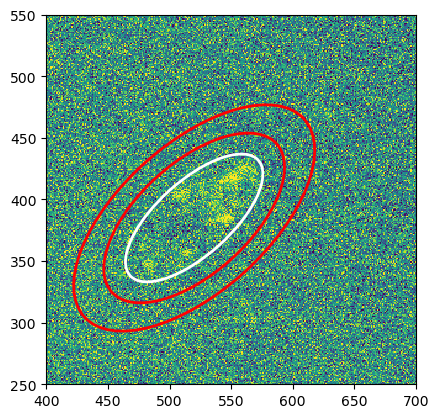

In [5]:
hfile = os.path.join('processed',obj,'H','combined','HminusR.fits')
hdu = fits.open(hfile)
header = hdu[0].header
sub_sci = hdu[0].data
sub_var = hdu[1].data

angdeg = params.value[params.param == 'angle'].values[0]
angrad = angdeg * np.pi / 180.
pos = (params.value[params.param == 'x'].values[0],
       params.value[params.param == 'y'].values[0])
aperture = EllipticalAperture(pos,
                              params.value[params.param == 'a'].values[0],
                              params.value[params.param == 'b'].values[0],
                              theta=angrad)
annulus = EllipticalAnnulus(pos,
                            params.value[params.param == 'ai'].values[0],
                            params.value[params.param == 'ao'].values[0],
                            params.value[params.param == 'bi'].values[0],
                            theta=angrad)

norm = simple_norm(sub_sci, 'linear', percent=95)
plt.imshow(sub_sci, norm=norm, interpolation='nearest')
plt.xlim(400, 700)
plt.ylim(250, 550)

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
an_patches = annulus.plot(color='red', lw=2,
                           label='Photometry annulus')

src_pho = aperture_photometry(sub_sci, aperture)
src_var = aperture_photometry(sub_var, aperture)

bgd_pho = aperture_photometry(sub_sci, annulus)
bgd_var = aperture_photometry(sub_var, annulus)

src_pho['aperture_sum'].info.format = '%.8g'
src_var['aperture_sum'].info.format = '%.8g'
bgd_pho['aperture_sum'].info.format = '%.8g'
bgd_var['aperture_sum'].info.format = '%.8g'

src_stats = ApertureStats(sub_sci, aperture)
bgd_stats = ApertureStats(sub_sci, annulus)

ratio = src_stats.sum_aper_area / bgd_stats.sum_aper_area
scaled_bgd_pho = bgd_pho['aperture_sum'] * ratio
scaled_bgd_var = bgd_var['aperture_sum'] * ratio

bgd_sub_pho = src_pho['aperture_sum'] - scaled_bgd_pho
bgd_sub_var = src_var['aperture_sum']

exptime = header['EXPTIME']
ctrt = bgd_sub_pho[0] / exptime # Ha + NII
ctrt_err = np.sqrt(bgd_sub_var[0]) / exptime # Ha + NII

NII_correction = 1.1

ctrt = ctrt / NII_correction
ctrt_err = ctrt_err / NII_correction

outFile = os.path.join('processed',obj,'H','combined','CountRate.csv')
df = pd.DataFrame({'CountRate':[ctrt], 'CountRate_Err':[ctrt_err]})
df.to_csv(outFile, index=False)

print('Bgd subtracted Ha (cts/s):', ctrt , 'p/m', ctrt_err)
print('SNR:', ctrt / ctrt_err)